# Chapter 10 - Exercise Solutions - Applied

In [2]:
import numpy as np, pandas as pd
from matplotlib.pyplot import subplots
from sklearn.linear_model import \
     (LinearRegression,
      LogisticRegression,
      Lasso)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from ISLP.torch import rec_num_workers
# from ISLP.torch import ErrorTracker
from sklearn.model_selection import \
     (train_test_split,
      GridSearchCV)
from sklearn.metrics import mean_squared_error

In [49]:
import torch
import torchinfo
from torch import nn, concat # Added concat
from torch.utils.data import TensorDataset
from torch.optim import RMSprop
from torch.utils.data import DataLoader # Added
from torch.utils.data import Dataset # Added
from torch.utils.data import random_split # Added
from pytorch_lightning.callbacks import Callback # Added
from torchmetrics import (MeanAbsoluteError,
                          R2Score,
                          Accuracy, # Added
                          MeanSquaredError) # Added
from torchinfo import summary # To summarize models

In [4]:
from pytorch_lightning import LightningDataModule # Added
from pytorch_lightning import LightningModule # Added
from pytorch_lightning.utilities import rank_zero_only # Added
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning import Trainer

In [54]:
from torchvision.io import read_image
# from torchvision.datasets import MNIST, CIFAR100
# from torchvision.models import (resnet50, ResNet50_Weights)
from torchvision.transforms import (Resize, Normalize, CenterCrop) # ToTensor
from torchvision.models import (resnet50, ResNet50_Weights) # Resnet weights
from glob import glob
import json

In [5]:
# staticmethod fromarrays removed
class BasicDataModule(LightningDataModule):

    def __init__(self, train_dataset, test_dataset, batch_size=32, num_workers=0, persistent_workers=True, validation=None, seed=0):

        super(BasicDataModule, self).__init__()

        ntrain = len(train_dataset)
        if type(validation) == float:
            nvalidation = int(validation * len(train_dataset))
        elif type(validation) == int:
            nvalidation = validation
        elif validation is None:
            nvalidation = 0

        if isinstance(validation, Dataset):
            (self.train_dataset, self.validation_dataset) = (train_dataset, validation)
        else:
            (self.train_dataset, self.validation_dataset) = random_split(train_dataset, [ntrain - nvalidation, nvalidation], generator=Generator().manual_seed(seed))
                
        self.test_dataset = test_dataset
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.persistent_workers = persistent_workers and num_workers > 0
        self.seed = seed
        
    def train_dataloader(self):
        return DataLoader(self.train_dataset, shuffle=True, batch_size=self.batch_size, num_workers=self.num_workers, persistent_workers=self.persistent_workers)

    # For validation, test, and predict we load the entire data at once in this simple module. Otherwise metrics get averaged over minibatch

    def val_dataloader(self):
        return DataLoader(self.validation_dataset, shuffle=False, batch_size=self.batch_size, num_workers=self.num_workers, persistent_workers=self.persistent_workers)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, num_workers=self.num_workers, persistent_workers=self.persistent_workers)

    def predict_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=len(self.test_dataset), num_workers=self.num_workers, persistent_workers=self.persistent_workers)


In [6]:
class BasicModule(LightningModule):

    """
    A simple `pytorch_lightning` module for regression problems.
    """

    def __init__(self, model, loss, optimizer=None, metrics=None, on_epoch=True, pre_process_y_for_metrics=lambda y: y):

        super(BasicModule, self).__init__()

        self.model = model
        self.loss = loss

        optimizer = optimizer or RMSprop(model.parameters())
        self._optimizer = optimizer
        self.metrics = metrics
        self.on_epoch = on_epoch
        self.pre_process_y_for_metrics = pre_process_y_for_metrics
        
    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        preds = self.forward(x)
        loss = self.loss(preds, y)
        self.log("train_loss", loss, on_epoch=self.on_epoch, on_step=False)

        y_ = self.pre_process_y_for_metrics(y)
        for _metric in self.metrics.keys():
            pl_metric = self.metrics[_metric]
            self.log(f"train_{_metric}", pl_metric(preds.to(pl_metric.device), y_.to(pl_metric.device)), on_epoch=self.on_epoch)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch

    @rank_zero_only
    def validation_step(self, batch, batch_idx):
        x, y = batch

    def predict_step(self, batch, batch_idx):
        x, y = batch
        return y, self.forward(x)

    def configure_optimizers(self):
        return self._optimizer

    @staticmethod
    def regression(model, metrics=None, device='cpu', **kwargs):

        if metrics is None:
            metrics = {}

        loss = nn.MSELoss().to(device)
        if device is not None:
            for key, metric in metrics.items():
                metrics[key] = metric.to(device)
        return BasicModule(model, loss, metrics=metrics, **kwargs)

    @staticmethod
    def binary_classification(model, metrics=None, device='cpu', **kwargs):

        if metrics is None:
            metrics = {}

        loss = nn.BCEWithLogitsLoss()
        if 'accuracy' not in metrics:
            metrics['accuracy'] = Accuracy('binary')
        if device is not None:
            for key, metric in metrics.items():
                metrics[key] = metric.to(device)
        return BasicModule(model, loss, metrics=metrics, pre_process_y_for_metrics = lambda x: x.int(), **kwargs)

    @staticmethod
    def classification(model, num_classes, metrics=None, device='cpu', **kwargs):
        if metrics is None:
            metrics = {}
        loss = nn.CrossEntropyLoss().to(device)
        if 'accuracy' not in metrics:
            metrics['accuracy'] = Accuracy('multiclass', num_classes=num_classes)
        if device is not None:
            for key, metric in metrics.items():
                metrics[key] = metric.to(device)

        return BasicModule(model, loss, metrics=metrics, **kwargs)

In [19]:
class BasicErrorTracker(Callback):

    def on_validation_epoch_start(self, trainer, pl_module):
        self.val_preds = []
        self.val_targets = []

    def on_validation_batch_start(self, trainer, pl_module, batch, batch_idx, dataloader_idx=0):
        x, y = batch
        self.val_preds.append(pl_module.forward(x))
        self.val_targets.append(y)

    def on_validation_epoch_end(self, trainer, pl_module):
        preds = concat(self.val_preds)
        targets = concat(self.val_targets)
        targets_ = pl_module.pre_process_y_for_metrics(targets)

        loss = pl_module.loss(preds, targets)
        pl_module.log("valid_loss", loss, on_epoch=pl_module.on_epoch)

        for _metric in pl_module.metrics.keys():
            pl_metric = pl_module.metrics[_metric]
            pl_module.log(f"valid_{_metric}",
                          pl_metric(preds.to(pl_metric.device), targets_.to(pl_metric.device)),
                          on_epoch=pl_module.on_epoch)

    def on_test_epoch_start(self, trainer, pl_module):
        self.test_preds = []
        self.test_targets = []

    def on_test_batch_start(self, trainer, pl_module, batch, batch_idx, dataloader_idx=0):
        x, y = batch
        self.test_preds.append(pl_module.forward(x))
        self.test_targets.append(y)

    def on_test_epoch_end(self, trainer, pl_module):
        preds = concat(self.test_preds)
        targets = concat(self.test_targets)
        targets_ = pl_module.pre_process_y_for_metrics(targets)
        
        loss = pl_module.loss(preds, targets)
        pl_module.log("test_loss", loss, on_epoch=pl_module.on_epoch)

        for _metric in pl_module.metrics.keys():
            pl_metric = pl_module.metrics[_metric]
            pl_module.log(f"test_{_metric}",
                          pl_metric(preds.to(pl_metric.device), targets_.to(pl_metric.device)),
                          on_epoch=pl_module.on_epoch)

## 6

Consider the simple function $ R(\beta) = sin(\beta) + \beta/10 $.

**(a)** Draw a graph of this function over the range $ \beta \in [−6, 6] $.


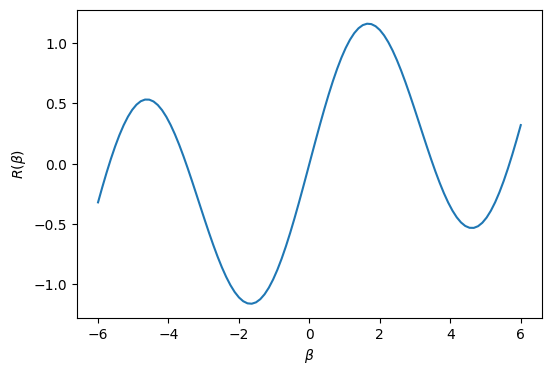

In [42]:
beta_series = np.linspace(-6, 6, 100)
R_series = np.sin(beta_series) + beta_series/10

fig, ax = subplots(1, 1, figsize=(6,4))
ax.plot(beta_series, R_series)
ax.set_xlabel(r'$\beta$')
ax.set_ylabel(r'$R(\beta)$');

**(b)** What is the derivative of this function?

$$ \frac{\partial}{\partial \beta} R(\beta) = \frac{\partial}{\partial \beta} \left[ sin(\beta) + \beta/10 \right] $$

$$ \frac{\partial}{\partial \beta} R(\beta) = cos(\beta) + 1/10  $$

Plot of $R(\beta)$ and its derivative. We can see that when $R(\beta)$ slopes downward, its derivative is negative.

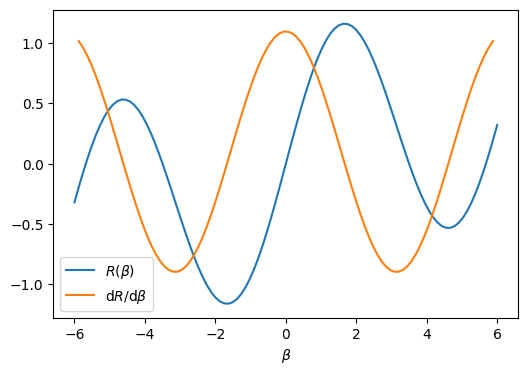

In [70]:
h = beta_series[1] - beta_series[0]
dR_dbeta = np.full_like(beta_series, np.nan)
dR_dbeta[1:-1] = (R_series[2:] - R_series[:-2]) / (2*h)

fig, ax = subplots(1, 1, figsize=(6,4))
ax.plot(beta_series, R_series, label=r'$R(\beta)$')
ax.plot(beta_series, dR_dbeta, label=r'd$R$/d$\beta$')
ax.set_xlabel(r'$\beta$')
ax.legend();

**(c)** Given $\beta_0 = 2.3$, run gradient descent to find a local minimum of $R(\beta)$ using a learning rate of $\rho = 0.1$. Show each of $\beta_0, \beta_1, ...$ in your plot, as well as the final answer.

Gradient descent involves updating the parameter $\beta$ by the gradient of $R(\beta)$ multiplied by a factor $\rho$.

$$ \beta^{m+1} \leftarrow \beta^{m} + \rho \nabla R(\beta^{m}) $$

In this case, $ \nabla R(\beta) $ is the simple partial derivative of $R$ with respect to $\beta$ evlauated at our intitial point $\beta_0$.

$$ \nabla R(\beta^{m}) = \frac{\partial}{\partial \beta} R(\beta) |_{\beta=\beta_0} $$

The initial position is $ \beta_0 = 2.3 $.

The first iteration is:

$ \frac{\partial}{\partial \beta} R(\beta) |_{\beta_0=2.3} = cos(\beta_0) + 1/10 = cos(2.3) + 1/10 = -0.66 + 1/10 = -0.56 $

$ \beta_{1} \leftarrow \beta_{0} - \rho \nabla R(\beta_{0}) $

$ \beta_{1} \leftarrow 2.3 - (0.1) (-0.56) $

$ \beta_{1} = 2.24 $

Test plot with the first two iterations:

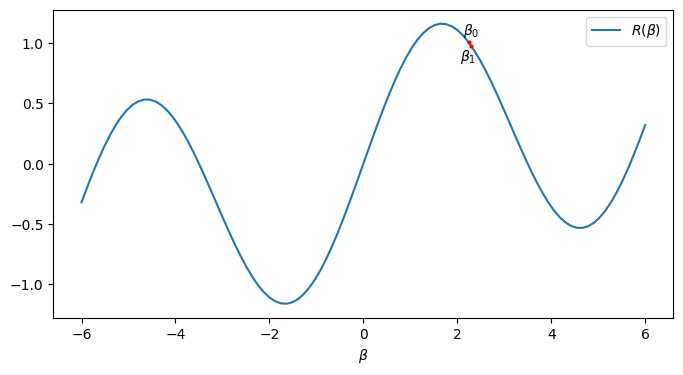

In [135]:
beta_0 = 2.3
R_0 = np.sin(beta_0) + beta_0/10

beta_1 = 2.24
R_1= np.sin(beta_1) + beta_1/10

fig, ax = subplots(1, 1, figsize=(8,4))
ax.plot(beta_series, R_series, label=r'$R(\beta)$')
ax.plot(beta_0, R_0, 'ro', markersize=2)
ax.text(beta_0, R_0 + 0.05, r'$\beta_0$', fontsize=10, verticalalignment='bottom', horizontalalignment='center')
ax.plot(beta_1, R_1, 'ro', markersize=2)
ax.text(beta_1, R_1 - 0.05, r'$\beta_1$', fontsize=10, verticalalignment='top', horizontalalignment='center')
ax.set_xlabel(r'$\beta$')
ax.legend();

Plot of the full descent series

In [201]:
gradient = 10 # Start with an arbitrarily large value
beta_list = [2.3]
rho = 0.1
while abs(gradient) > 0.1:
    gradient = np.cos(beta_list[-1]) + 1/10
    beta_list.append(beta_list[-1] - rho * gradient)

len(beta_list)

42

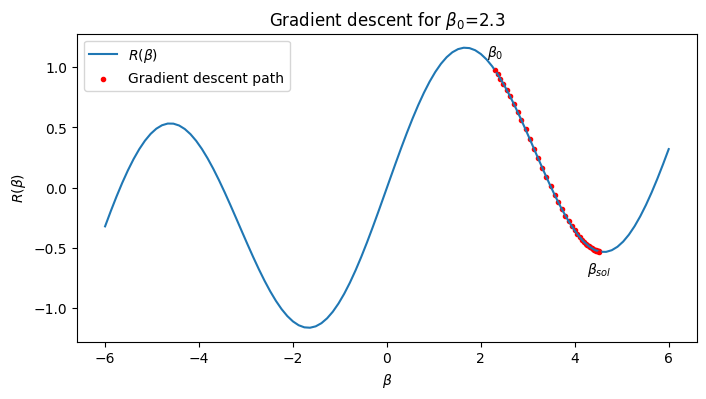

In [203]:
beta_array = np.array(beta_list)
R_array= np.sin(beta_array) + beta_array/10

fig, ax = subplots(1, 1, figsize=(8,4))
ax.plot(beta_series, R_series, label=r'$R(\beta)$')
ax.scatter(beta_array, R_array, color='r', marker='.', label='Gradient descent path')
ax.plot(beta_array[0], R_array[0], 'ro', markersize=2)
ax.text(beta_array[0], R_array[0] + 0.07, r'$\beta_0$', fontsize=10, verticalalignment='bottom', horizontalalignment='center')
ax.plot(beta_array[-1], R_array[-1], 'ro', markersize=2)
ax.text(beta_array[-1], R_array[-1] - 0.07, r'$\beta_{sol}$', fontsize=10, verticalalignment='top', horizontalalignment='center')
ax.set_xlabel(r'$\beta$')
ax.set_ylabel(r'$R(\beta)$')
ax.set_title(r'Gradient descent for $\beta_0$=2.3')
ax.legend(loc='upper left');

**(d)** Repeat with $\beta_0 = 1.4$.

In [205]:
gradient = 10 # Start with an arbitrarily large value
beta_list = [1.4]
rho = 0.1
while abs(gradient) > 0.1:
    gradient = np.cos(beta_list[-1]) + 1/10
    beta_list.append(beta_list[-1] - rho * gradient)

len(beta_list)

52

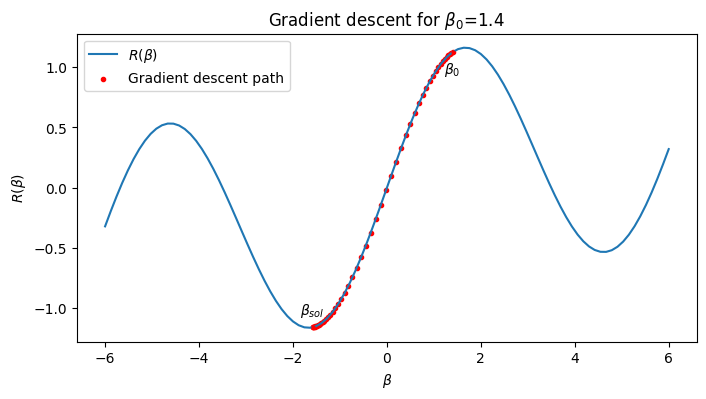

In [206]:
beta_array = np.array(beta_list)
R_array= np.sin(beta_array) + beta_array/10

fig, ax = subplots(1, 1, figsize=(8,4))
ax.plot(beta_series, R_series, label=r'$R(\beta)$')
ax.scatter(beta_array, R_array, color='r', marker='.', label='Gradient descent path')
ax.plot(beta_array[0], R_array[0], 'ro', markersize=2)
ax.text(beta_array[0], R_array[0] - 0.07, r'$\beta_0$', fontsize=10, verticalalignment='top', horizontalalignment='center')
ax.plot(beta_array[-1], R_array[-1], 'ro', markersize=2)
ax.text(beta_array[-1], R_array[-1] + 0.07, r'$\beta_{sol}$', fontsize=10, verticalalignment='bottom', horizontalalignment='center')
ax.set_xlabel(r'$\beta$')
ax.set_ylabel(r'$R(\beta)$')
ax.set_title(r'Gradient descent for $\beta_0$=1.4')
ax.legend(loc='upper left');

## 7

Fit a neural network to the `Default` data. Use a single hidden layer with 10 units, and dropout regularization. Have a look at Labs 10.9.1–10.9.2 for guidance. Compare the classification performance of your model with that of linear logistic regression.

In [7]:
Default = load_data('Default')
Default = pd.get_dummies(Default.iloc[:,0:2]).merge(Default.iloc[:,2:4], left_index=True, right_index=True)

In [8]:
Default['intercept'] = 1
Default = Default.drop(columns=['default_No', 'student_No'])

In [9]:
Y = Default['default_Yes'].to_numpy()
X = Default.drop(columns='default_Yes').to_numpy()

In [10]:
(X_train, X_test, Y_train, Y_test) = train_test_split(X, Y, test_size=1/3, random_state=1)

### Linear Model

In [11]:
Default_lin = LinearRegression().fit(X_train, Y_train)
Yhat_test = Default_lin.predict(X_test)
mean_squared_error(Y_test, Yhat_test)

0.026045203197352523

### Logistic Model

In [12]:
Default_log = LogisticRegression().fit(X_train, Y_train)
Yhat_test = Default_log.predict(X_test)
mean_squared_error(Y_test, Yhat_test)

0.027294541091781643

### Lasso Model

In [13]:
scaler = StandardScaler(with_mean=True, with_std=True)
lasso = Lasso(warm_start=True, max_iter=30000)

In [15]:
X_train_scaled = scaler.fit_transform(X_train)
n = X_train_scaled.shape[0]
lam_max = np.fabs(X_train_scaled.T.dot(Y_train - Y_train.mean())).max() / n
param_grid = {'alpha': np.exp(np.linspace(0, np.log(0.01), 100)) * lam_max}

In [16]:
cv = KFold(10, shuffle=True, random_state=1)
grid = GridSearchCV(lasso, param_grid, cv=cv, scoring='neg_mean_absolute_error')
grid.fit(X_train, Y_train);

In [17]:
trained_lasso = grid.best_estimator_
Yhat_test = trained_lasso.predict(X_test)
# np.fabs(Yhat_test - Y_test).mean()
mean_squared_error(Y_test, Yhat_test)

0.026034929072466143

### Single Layer Neural Network

In [31]:
class DefaultSingleLayer(nn.Module):

    def __init__(self, input_size):
        super(DefaultSingleLayer, self).__init__()
        self.flatten = nn.Flatten()
        self.layer1 = nn.Sequential(
            nn.Linear(input_size, 10), # input_size x 10 parameters + 10 (bias)
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(10, 1)) # 10 parameters + 1 (bias)

    def forward(self, x):
        x = self.flatten(x)
        x = self.layer1(x)
        x = torch.flatten(x)
        return x

In [32]:
Default_nn = DefaultSingleLayer(X.shape[1]) # input_size = 4

In [33]:
torchinfo.summary(Default_nn, input_size=X_train.shape, col_names=['input_size', 'output_size', 'num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
DefaultSingleLayer                       [6666, 4]                 [6666]                    --
├─Flatten: 1-1                           [6666, 4]                 [6666, 4]                 --
├─Sequential: 1-2                        [6666, 4]                 [6666, 1]                 --
│    └─Linear: 2-1                       [6666, 4]                 [6666, 10]                50
│    └─ReLU: 2-2                         [6666, 10]                [6666, 10]                --
│    └─Dropout: 2-3                      [6666, 10]                [6666, 10]                --
│    └─Linear: 2-4                       [6666, 10]                [6666, 1]                 11
Total params: 61
Trainable params: 61
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.41
Input size (MB): 0.11
Forward/backward pass size (MB): 0.59
Params size (MB): 0.00
Estimated Total Size (MB): 0.69

In [34]:
X_train_t = torch.tensor(X_train.astype(np.float32))
Y_train_t = torch.tensor(Y_train.astype(np.float32))
Default_train = TensorDataset(X_train_t, Y_train_t)

In [35]:
X_test_t = torch.tensor(X_test.astype(np.float32))
Y_test_t = torch.tensor(Y_test.astype(np.float32))
Default_test = TensorDataset(X_test_t, Y_test_t)

In [36]:
max_num_workers = rec_num_workers()

In [37]:
Default_DataModule = BasicDataModule(Default_train, Default_test, batch_size=32, num_workers=min(4, max_num_workers), validation=Default_test)

In [38]:
# Default_Module = BasicModule.regression(Default_nn, metrics={'mae':MeanAbsoluteError()})
Default_Module = BasicModule.regression(Default_nn, metrics={'mse':MeanSquaredError()})

In [39]:
Default_logger = CSVLogger('logs', name='DefaultDatasetQ7')

Note custom `BasicErrorTracker()` function

In [40]:
Default_Trainer = Trainer(deterministic=True, max_epochs=50, log_every_n_steps=5, logger=Default_logger, callbacks=[BasicErrorTracker()])
Default_Trainer.fit(Default_Module, datamodule=Default_DataModule)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type               | Params
---------------------------------------------
0 | model | DefaultSingleLayer | 61    
1 | loss  | MSELoss            | 0     
---------------------------------------------
61        Trainable params
0         Non-trainable params
61        Total params
0.000     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 209/209 [00:01<00:00, 166.49it/s, v_num=1]       

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 209/209 [00:01<00:00, 165.75it/s, v_num=1]


In [41]:
Default_Trainer.test(Default_Module, datamodule=Default_DataModule, verbose=True)

Testing DataLoader 0: 100%|██████████| 105/105 [00:00<00:00, 688.10it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss          0.029709739610552788
        test_mse            0.02970973588526249
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.029709739610552788, 'test_mse': 0.02970973588526249}]

## 8

From your collection of personal photographs, pick 10 images of animals (such as dogs, cats, birds, farm animals, etc.). If the subject does not occupy a reasonable part of the image, then crop the image. Now use a pretrained image classification CNN as in Lab 10.9.4 to predict the class of each of your images, and report the probabilities for the top five predicted classes for each image.

### Format the imput images

Resize, crop, and nomralize (according to ResNet means and standard deviations)

In [45]:
resize = Resize((232,232), antialias=True)
crop = CenterCrop(224)
normalize = Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
imgfiles = sorted([f for f in glob('images/*')])
imgs = torch.stack([torch.div(crop(resize(read_image(f))), 255) for f in imgfiles])
imgs = normalize(imgs)
imgs.size()

torch.Size([10, 3, 224, 224])

### Load the pre-trained weights

Proviced by `torchvision.models`

In [50]:
resnet_model = resnet50(weights=ResNet50_Weights.DEFAULT)
summary(resnet_model, input_data=imgs, col_names=['input_size', 'output_size', 'num_params']) 

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
ResNet                                   [10, 3, 224, 224]         [10, 1000]                --
├─Conv2d: 1-1                            [10, 3, 224, 224]         [10, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [10, 64, 112, 112]        [10, 64, 112, 112]        128
├─ReLU: 1-3                              [10, 64, 112, 112]        [10, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [10, 64, 112, 112]        [10, 64, 56, 56]          --
├─Sequential: 1-5                        [10, 64, 56, 56]          [10, 256, 56, 56]         --
│    └─Bottleneck: 2-1                   [10, 64, 56, 56]          [10, 256, 56, 56]         --
│    │    └─Conv2d: 3-1                  [10, 64, 56, 56]          [10, 64, 56, 56]          4,096
│    │    └─BatchNorm2d: 3-2             [10, 64, 56, 56]          [10, 64, 56, 56]          128
│    │    └─ReLU: 3-3      

In [51]:
resnet_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Feed the images into the network

Obtain predictions and predicted probabilities, normalized with a `softamax()` function

In [53]:
img_preds = resnet_model(imgs)
img_probs = np.exp(np.asarray(img_preds.detach()))
img_probs /= img_probs.sum(1)[:,None]

In [60]:
img_preds.shape

torch.Size([10, 1000])

### Apply data labels

In [56]:
labs = json.load(open('Data/imagenet_class_index.json'))
class_labels = pd.DataFrame([(int(k), v[1]) for k, v in labs.items()], columns=['idx', 'label'])
class_labels = class_labels.set_index('idx')
class_labels = class_labels.sort_index()

In [61]:
class_labels

,label
idx,
0,tench
1,goldfish
2,great_white_shark
3,tiger_shark
4,hammerhead
...,...
995,earthstar
996,hen-of-the-woods
997,bolete


In [127]:
result = []

for i, imgfile in enumerate(imgfiles):
    img_df = class_labels.copy()
    img_df['prob'] = img_probs[i]
    img_df = img_df.sort_values(by='prob', ascending=False)[:10]
    img_df.reset_index(drop=True, inplace=True)
    img_df.columns = pd.MultiIndex.from_product([[f'{imgfiles[i]}'], img_df.columns])
    result.append(img_df)

result_df = pd.concat(result, axis=1)
result_df

images/cat-2.jpg           images/cat.jpg           images/cow-2.jpg  \
             label      prob          label      prob            label   
0    jigsaw_puzzle  0.535954      tiger_cat  0.077034               ox   
1        tile_roof  0.131623          tabby  0.045406            bison   
2     Egyptian_cat  0.043090   space_heater  0.037731             plow   
3            tabby  0.028779   Egyptian_cat  0.034630    water_buffalo   
4           barrow  0.024349  window_screen  0.025140           oxcart   
5        tiger_cat  0.014563        doormat  0.020901             lion   
6      Siamese_cat  0.003936      seat_belt  0.015976       hartebeest   
7           shield  0.002509       strainer  0.014132       worm_fence   
8             lynx  0.002357            wok  0.010606           muzzle   
9    manhole_cover  0.002329     chain_mail  0.007755           sorrel   

            images/cow.jpg             images/crab.jpg            \
       prob          label      prob             label      prob   
0  0.255884             ox  0.246795         rock_crab  0.385034   
1  0.029800         oxcart  0.062597    Dungeness_crab  0.069247   
2  0.026854         impala  0.043976         king_crab  0.040805   
3  0.025040        gazelle  0.032080      fiddler_crab  0.023331   
4  0.021786          bison  0.013497       hermit_crab  0.014947   
5  0.017926           plow  0.013443            isopod  0.002910   
6  0.008663  water_buffalo  0.009232          crayfish  0.002881   
7  0.008205     worm_fence  0.007827     spiny_lobster  0.001462   
8  0.007023            ram  0.006527  American_lobster  0.001424   
9  0.006862         sorrel  0.003413             dough  0.001362   

          images/dog-2.jpg                        images/dog.jpg            \
                     label      prob                       label      prob   
0                 Shih-Tzu  0.234479        Bernese_mountain_dog  0.225948   
1          Tibetan_terrier  0.158301                 Appenzeller  0.079797   
2                    Lhasa  0.061553               Border_collie  0.030536   
3     Old_English_sheepdog  0.008568                      collie  0.022082   
4                   collie  0.004085                 EntleBucher  0.010465   
5         English_springer  0.003311           Shetland_sheepdog  0.009034   
6  wire-haired_fox_terrier  0.002795  Greater_Swiss_Mountain_dog  0.007772   
7            Border_collie  0.002775                    Pembroke  0.007709   
8                 Cardigan  0.002433             Tibetan_mastiff  0.005109   
9      miniature_schnauzer  0.002253                    Cardigan  0.003796   

      images/fish.jpg                     images/lion.jpg            \
                label      prob                     label      prob   
0                reel  0.145235                      lion  0.350197   
1          barracouta  0.084449                    cougar  0.007326   
2            goldfish  0.075501                      lynx  0.001593   
3                coho  0.059539  Chesapeake_Bay_retriever  0.001286   
4               tench  0.050141                      chow  0.001237   
5            sturgeon  0.005425              Egyptian_cat  0.001236   
6                pole  0.005136                bloodhound  0.001227   
7                 gar  0.003758                    jaguar  0.001167   
8  long-horned_beetle  0.002162                     hyena  0.001131   
9           boathouse  0.002144                 tiger_cat  0.001110   

  images/monkey.jpg            
              label      prob  
0   squirrel_monkey  0.054868  
1     spider_monkey  0.029701  
2         birdhouse  0.026647  
3           macaque  0.023472  
4               pot  0.016415  
5              titi  0.015670  
6  three-toed_sloth  0.015586  
7         orangutan  0.015328  
8            langur  0.014299  
9  proboscis_monkey  0.013859